<a href="https://colab.research.google.com/github/jerryjerry9/FRI_ML/blob/main/hw1_pratice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [17]:
training_data = datasets.FashionMNIST(
    root="data",            # 資料放置路徑
    train=True,             # 訓練資料集
    download=True,          # 自動下載
    transform=ToTensor(),   # 資料轉換函數
)

In [18]:
test_data = datasets.FashionMNIST(
    root="data",            # 資料放置路徑
    train=False,            # 測試資料集
    download=True,          # 自動下載
    transform=ToTensor(),   # 資料轉換函數
)

In [19]:
# 批次載入資料筆數
batch_size = 64

# 建立 DataLoader
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [20]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [21]:
# 各類別名稱
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [22]:
# 定義類神經網路模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # 建立類神經網路各層
        self.flatten = nn.Flatten()  # 轉為一維向量
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),   # 線性轉換
            nn.ReLU(),               # ReLU 轉換
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # 定義資料如何通過類神經網路各層
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# 若 CUDA 環境可用，則使用 GPU 計算，否則使用 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [23]:
# 建立類神經網路模型，並放置於 GPU 或 CPU 上
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [24]:
# 損失函數
loss_fn = nn.CrossEntropyLoss()

# 學習優化器
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [25]:
# 訓練模型
def train(dataloader, model, loss_fn, optimizer):
    # 資料總筆數
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # 將模型設定為訓練模式
    model.train()
    train_loss = 0
    # 批次讀取資料進行訓練
    for batch, (X, y) in enumerate(dataloader):
        # 將資料放置於 GPU 或 CPU
        X, y = X.to(device), y.to(device)

        pred = model(X)         # 計算預測值
        loss = loss_fn(pred, y) # 計算損失值（loss）
        train_loss += loss_fn(pred, y).item()
        optimizer.zero_grad()   # 重設參數梯度（gradient）
        loss.backward()         # 反向傳播（backpropagation）
        optimizer.step()        # 更新參數
    train_loss /= num_batches
    return(train_loss)

In [26]:
# 測試模型
def test(dataloader, model, loss_fn):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 批次數量
    num_batches = len(dataloader)

    # 將模型設定為驗證模式
    model.eval()

    # 初始化數值
    test_loss, correct = 0, 0

    # 驗證模型準確度
    with torch.no_grad():  # 不要計算參數梯度
        for X, y in dataloader:
            # 將資料放置於 GPU 或 CPU
            X, y = X.to(device), y.to(device)

            # 計算預測值
            pred = model(X)

            # 計算損失值的加總值
            test_loss += loss_fn(pred, y).item()

            # 計算預測正確數量的加總值
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # 計算平均損失值與正確率
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss , correct*100

In [27]:
# 設定 epochs 數
epochs = 100
total_trainloss = np.zeros((epochs)) 
total_testloss = np.zeros((epochs)) 
total_acc = np.zeros((epochs)) 
# 開始訓練模型
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainloss_1 = train(train_dataloader, model, loss_fn, optimizer)
    testloss,acc = test(test_dataloader, model, loss_fn)
    trainloss,acc1 = test(train_dataloader, model, loss_fn)
    total_trainloss[t] = trainloss
    total_testloss[t] = testloss
    total_acc[t] = acc
print('done')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 47.4%, Avg loss: 2.173905 

Test Error: 
 Accuracy: 48.3%, Avg loss: 2.173003 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.942290 

Test Error: 
 Accuracy: 56.0%, Avg loss: 1.940231 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 59.2%, Avg loss: 1.571263 

Test Error: 
 Accuracy: 59.9%, Avg loss: 1.567083 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 63.5%, Avg loss: 1.274856 

Test Error: 
 Accuracy: 64.1%, Avg loss: 1.268274 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 64.8%, Avg loss: 1.096404 

Test Error: 
 Accuracy: 65.8%, Avg loss: 1.087644 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.986268 

Test Error: 
 Accuracy: 67.0%, Avg loss: 0.975671 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 67.1%, Avg loss: 0.913165 

Test Error: 
 Accuracy: 68.2%, Avg loss: 0.9

In [29]:
# 儲存模型參數
date_test = '0921_train_final_loss'
torch.save(model.state_dict(), 'drive/MyDrive/ml_data/hw01/model_'+ date_test  +'_100epoch.pth')

with open('drive/MyDrive/ml_data/hw01/total_train_loss_'+ date_test  +'.pkl', 'wb') as f:
     pickle.dump(total_trainloss, f)
with open('drive/MyDrive/ml_data/hw01/total_test_loss_'+ date_test  +'.pkl', 'wb') as f:
     pickle.dump(total_testloss, f)
with open('drive/MyDrive/ml_data/hw01/total_acc_'+ date_test  +'.pkl', 'wb') as f:
     pickle.dump(total_acc, f)

In [30]:
# 建立類神經網路模型
model2 = NeuralNetwork()

# 載入模型參數
model2.load_state_dict(torch.load('drive/MyDrive/ml_data/hw01/model_'+ date_test  +'_100epoch.pth'))

<All keys matched successfully>

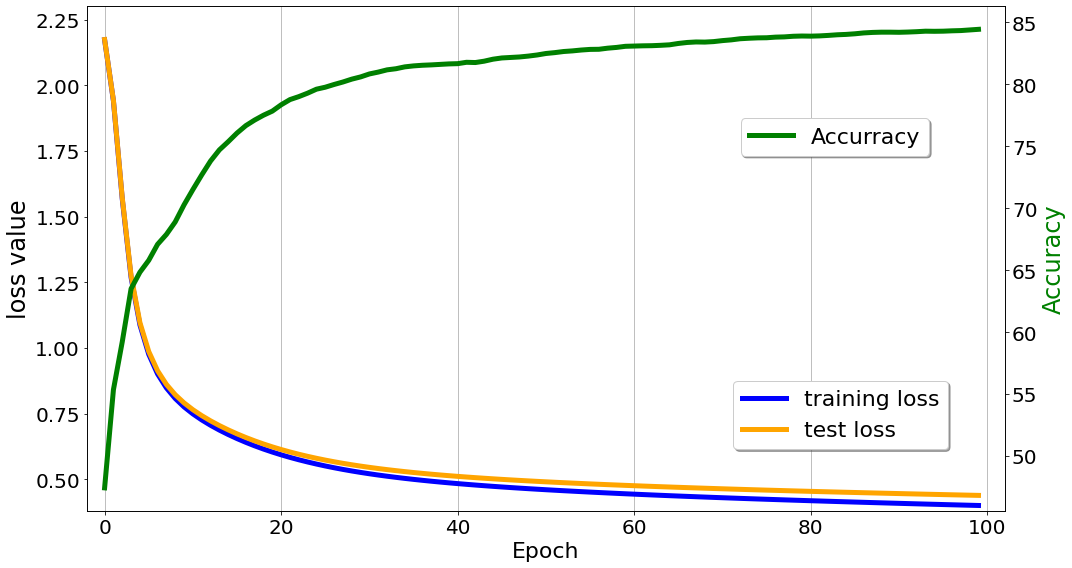

In [61]:
f,ax1= plt.subplots(figsize=(15,8))

ax1.plot(total_trainloss,linewidth=5,c='blue')
ax1.plot(total_testloss,linewidth=5,c='orange')
plt.legend(["training loss","test loss",],fontsize=22,shadow=True,loc=4,bbox_to_anchor=(0.95,0.1))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('loss value',fontsize=24)
ax1.set_xlabel('Epoch',color='k',fontsize=22)
ax1.grid(axis='x')
plt.axis([-2,102,0.38,2.3])


ax2 = ax1.twinx()
ax2.plot(total_acc,linewidth=5,c='green')
plt.ylabel('Accuracy',fontsize=24,c='green')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(["Accurracy"],fontsize=22,shadow=True,loc=2,bbox_to_anchor=(0.7,0.8))
plt.tight_layout()
plt.savefig('drive/MyDrive/ml_data/hw01/loss_'+date_test+'.png',dpi=400)

In [40]:
model2.eval()
pred_result = np.zeros((10000))
truth = np.zeros((10000))
for i in range(0,10000):
# 取得測試資料
  #print(x)
  x, y = test_data[i][0], test_data[i][1]
  pred = model2(x)
  #cm[pred[0].argmax(0),y]=cm[pred[0].argmax(0),y]+1
  pred_result[i] = pred[0].argmax(0)
  truth[i] = y

In [41]:
with open('drive/MyDrive/ml_data/hw01/test_data_prediction_'+ date_test  +'.pkl', 'wb') as f:
     pickle.dump(pred_result, f)
with open('drive/MyDrive/ml_data/hw01/test_data_truth_'+ date_test  +'.pkl', 'wb') as f:
     pickle.dump(truth, f)

In [42]:
hist_pred = np.histogram2d(pred_result,truth)

In [43]:
nparray_h = hist_pred[0]
print(nparray_h.shape)

(10, 10)


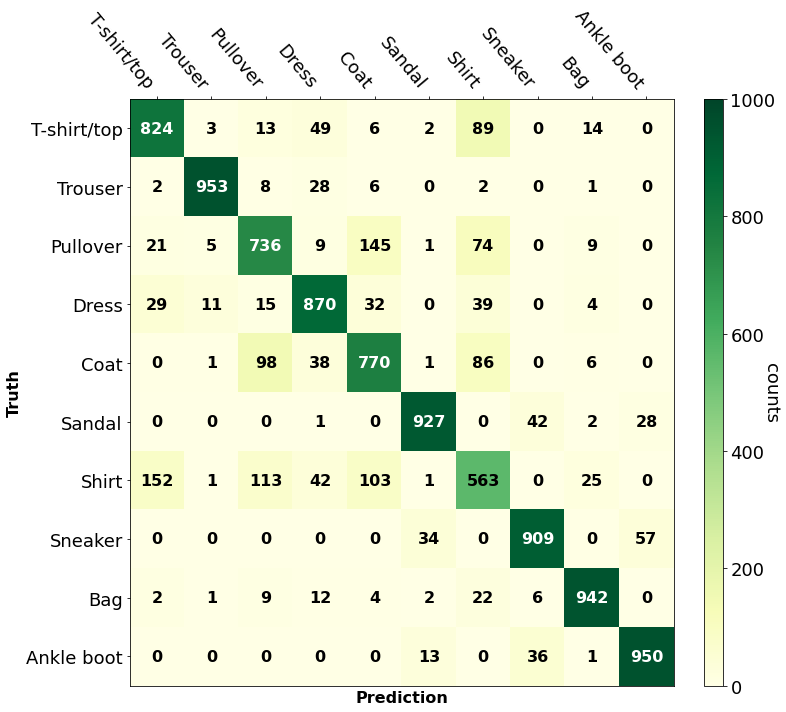

In [44]:
f,ax= plt.subplots(figsize=(11,10))
#ax.hist2d(pred_result, truth,bins=10,cmap='YlGn')
hitplot = ax.pcolormesh(nparray_h,cmap='YlGn',vmax=1000)
for xx in range(0,10):
  for yy in range(0,10):
    if nparray_h[xx,yy] > 600:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='w', size=16,fontweight='semibold',ha='center',va='center')
    else:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='k', size=16,fontweight='semibold',ha='center',va='center')
ax.invert_yaxis()
plt.ylabel('Truth',fontsize=16,fontweight='semibold',rotation=90)
plt.xlabel('Prediction',fontsize=16,fontweight='semibold')
plt.xticks(np.arange(0.5,10,1),classes,fontsize=18,rotation=310,horizontalalignment='right')
ax.xaxis.tick_top()
plt.yticks(np.arange(0.5,10,1),classes,fontsize=18)
cb = plt.colorbar(hitplot,aspect=30,fraction=0.05, pad=0.05)
cb.ax.tick_params(labelsize=18)
cb.set_label('counts', size=18,rotation=270)
plt.tight_layout()
plt.savefig('drive/MyDrive/ml_data/hw01/heatmap_pcolor_' + date_test + '.png',dpi=400)

In [59]:
wrong_mask = np.abs(truth-pred_result)
wrong=np.zeros((9))
a=0
for i in range(1840,1920):
  if wrong_mask[i]:
    wrong[a] = i
    a=a+1
    print('wrong',a)
    print('   ',classes[int(truth[i])])
    print('   ',classes[int(pred_result[i])])

wrong 1
    Bag
    Shirt
wrong 2
    Dress
    Coat
wrong 3
    Coat
    Pullover
wrong 4
    T-shirt/top
    Shirt
wrong 5
    T-shirt/top
    Shirt
wrong 6
    Coat
    Shirt
wrong 7
    Coat
    Pullover
wrong 8
    Ankle boot
    Sandal
wrong 9
    Coat
    Pullover


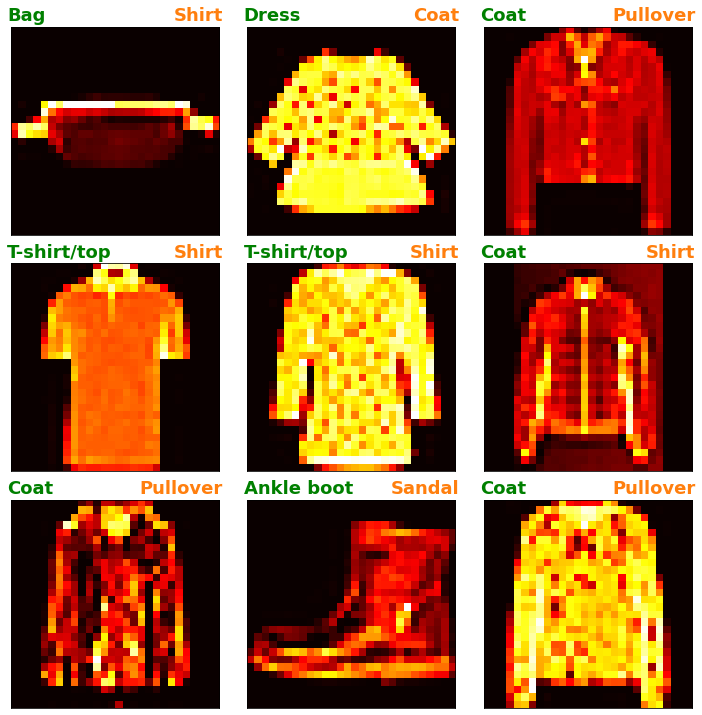

In [60]:

fig, ax = plt.subplots(3,3,figsize=(10,10))
a=0
for i in range(0,3):
  for j in range(0,3):
    xx, yy = test_data[int(wrong[a])][0], test_data[int(wrong[a])][1]
    ax[i,j].imshow(xx[0,:,:],cmap='hot')
    #title =  classes[yy] + ' vs ' + classes[int(pred_result[int(wrong[a])])]
    title1 =  classes[yy]
    title2 =  classes[int(pred_result[int(wrong[a])])]
    ax[i,j].text(-1, -2, title1,color='green', size=18,fontweight='semibold',ha='left',va='center')
    #ax[i,j].text(13, -2, ' vs ',color='k', size=14,fontweight='semibold',ha='center',va='center')
    ax[i,j].text(28, -2, title2,color='tab:orange', size=18,fontweight='semibold',ha='right',va='center')
    #ax[i,j].set_title(classes[yy],fontsize=20)
    #ax[i,j].set_title(title,fontsize=20)
    ax[i,j].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    a=a+1
plt.tight_layout()
plt.savefig('drive/MyDrive/ml_data/hw01/class_demo_0921.png',dpi=400)